In [361]:
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations, permutations

In [362]:
class MeaningIndex(Enum):
    CITY1 = 0
    CITY2 = 1
    DISTANCE = 2
    TRAFFIC_JAM = 3
    RATE_HAVE_POLICE = 4


NUMBER_CITY = 5
NUMBER_POPULATION = 50
NUMBER_SOLUTION = 50
NUMBER_NEIGHBORHOOD = 5
NUMBER_TARGET = len(MeaningIndex) - 2
RATE_SELECT_MOM_ALLEN = 0.5
RATE_MUTATION = 0.3

In [363]:
def isDominated(dominance, dominated):
    if dominance == dominated:
        return False
    for i, value in enumerate(dominance):
        if dominated[i] > value:
            return False    
    return True
isDominated([1,2,3], [0,2.0,3])


True

In [364]:
def existDominance(dominated, solutions):
    for dominance in solutions:
        if isDominated(dominance, dominated):
            return True
    return False

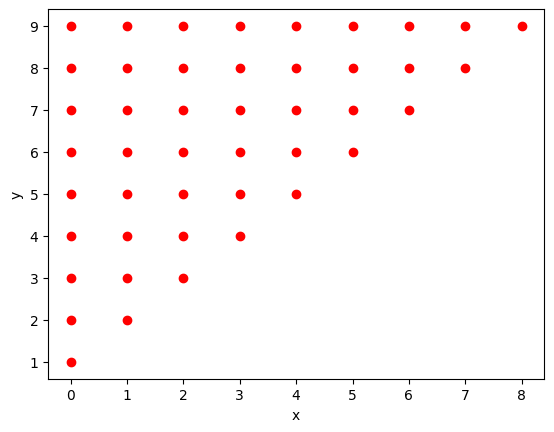

In [365]:
graph = pd.read_csv('./costEdges.csv').to_numpy()
plt.plot(graph[:, 0], graph[:, 1], "ro")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [366]:
def initialPopulation (size, numberCity):
    population = np.array([np.random.permutation(numberCity) for i in range(size)])
    return population

In [367]:
def initReferencePoint(numberSolutions):
    return np.zeros((numberSolutions,))+np.Infinity

In [368]:
def initWeightVector(numberSolutions):
    randomVectors = np.random.rand(numberSolutions, 3)
    weightVectors=np.array([weightVector/weightVector.sum() for weightVector in randomVectors])
    return weightVectors


In [369]:
def generateNeighborhoods(weightVectors, numberNeighbor):
    lenWeightVectors = len(weightVectors)
    def eachElement(index):
        neighborhood = []
        neighborDistance = []
        for i in range(lenWeightVectors):
            if i == index:
                continue
            distance = np.linalg.norm(weightVectors[index]-weightVectors[i])
            if len(neighborhood) < numberNeighbor:
                neighborDistance.append(distance)
                neighborhood.append(i)
            else:
                longestNeighbor = np.argmax(neighborDistance)
                if (distance<neighborDistance[longestNeighbor]):
                    del neighborDistance[longestNeighbor]
                    del neighborhood[longestNeighbor]
                    neighborDistance.append(distance)
                    neighborhood.append(i)
        return neighborhood
    matrixNeighbor =[]
    for i in range(lenWeightVectors):
        matrixNeighbor.append(eachElement(i))
    return np.array(matrixNeighbor)


In [370]:
def crossover(dad, mom):
    allenPicker = np.random.rand(NUMBER_CITY)
    setCity = range(NUMBER_CITY)
    child = np.copy(dad)
    momAllen = np.where(allenPicker < RATE_SELECT_MOM_ALLEN)[0] 
    dadAllen = np.where(allenPicker >= RATE_SELECT_MOM_ALLEN)[0]
    momAllenIndex, dadAllenIndex = [], []
    for i in range(NUMBER_CITY):
        if mom[i] in momAllen:
            momAllenIndex.append(i)
        if dad[i] in dadAllen:
            dadAllenIndex.append(i)
    child[momAllenIndex] = mom[momAllenIndex]
    setExistIndex =  set(momAllenIndex+dadAllenIndex)
    setEmptyIndex = set(setCity) -setExistIndex 
    missingIndex = list(setEmptyIndex)
    missingCity = [x for x in (set(setCity) - set(child))]
    np.random.shuffle(missingCity)
    child[missingIndex] = missingCity
    return child

In [371]:
def mutation(child):
    allenPicker = np.random.rand(NUMBER_CITY)
    mutationIndex = np.where(allenPicker <= RATE_MUTATION)[0]
    tmp = child[mutationIndex]
    np.random.shuffle(tmp)
    child[mutationIndex] = tmp
    return child

In [372]:
def cal(solution, matrixCost):
    edges = matrixCost[:,:2]
    cost =[0,0,0]
    for i in range(NUMBER_CITY-1):
        city1 = solution[i]
        city2 = solution[i+1]
        index = [index for index, edge in enumerate(edges) if list(edge)==[city1, city2] or list(edge)==[city2, city1]][0]
        cost +=matrixCost[index, 2:5]
    return cost

In [373]:
def updateReferencePoint(child, matrixCost, reference):
    FV = cal(child, matrixCost)
    updatedIds = [i for i, value in enumerate(reference) if reference[i]>FV[i]]
    reference[updatedIds] = FV[updatedIds]
    return reference


In [374]:
def updateNeighboringSolution(neighbor, neighborIndex, weightVectors, matrixCost, solution, reference, population):
    costs = cal(solution, matrixCost)
    def calOptimizeFunction(costs, weightVector):
        vector = abs(costs - reference)
        return max([weight*cost for weight, cost in zip(weightVector, vector)])
    fitnessChild = calOptimizeFunction(costs, weightVectors[neighborIndex])
    updatedNeighbor = []
    for index in neighbor:
        costs = cal(population[index], matrixCost)
        fitness = calOptimizeFunction(costs, weightVectors[index])
        if (fitnessChild< fitness):
            population[index] = solution
            updatedNeighbor.append(index)
    return neighbor, updatedNeighbor

In [380]:
class PrepareData:
    def __init__(self, numberCity: int) -> None:
        self.numberCity = numberCity
        self.FV = []
        self.startSolution = np.arange(numberCity)
        self.solutions = [list(x) for x in permutations(self.startSolution)]
        maxIndex = numberCity -1
        edges = np.array([edge for edge in combinations(range(numberCity), 2)])
        self.countEdges = len(edges)
        costs = np.concatenate((
            np.random.randint(100, size=(self.countEdges, 2)),
            np.random.rand(self.countEdges, 1)), axis=1)

        self.costEdges = np.concatenate((edges, costs), axis=1)
    def paretoFront(self):
        for solution in self.solutions:
            fv = cal(solution, self.costEdges)
            if not existDominance(fv, self.FV):
                self.FV.append(fv)
                self.solutions.append(solution)
        print('number pareto: ', len(self.solutions))
        pd.DataFrame(self.solutions).to_csv('./paretoSolution.csv', index=False)
        pd.DataFrame(self.FV).to_csv('./paretoFront.csv', index=False)

    def writeToCsv(self):
        pd.DataFrame(self.costEdges).to_csv('./costEdges.csv', index=False)
prepareData = PrepareData(NUMBER_CITY)
prepareData.paretoFront()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [376]:
def execute():
    iter = 0
    edgeCost = pd.read_csv('./costEdges.csv').to_numpy()
    weightVectors = initWeightVector(NUMBER_SOLUTION)
    population = initialPopulation(NUMBER_POPULATION, NUMBER_CITY)
    print(population[1])
    neighborhoods = generateNeighborhoods(weightVectors, NUMBER_NEIGHBORHOOD)
    referencePoints = initReferencePoint(NUMBER_TARGET)
    while iter < 1000:
        iter += 1
        childIndex = np.random.randint(NUMBER_CITY)
        parentIndex = np.random.choice(neighborhoods[childIndex], 2)
        parent = population[parentIndex]

        tempChild = crossover(parent[0], parent[1])
        child = mutation(tempChild)
        
        updateReferencePoint(child, edgeCost, referencePoints)
        updateNeighboringSolution(
            neighborhoods[childIndex], childIndex, weightVectors, edgeCost, child, referencePoints, population)
    
    FV = [cal(solution, edgeCost) for solution in population]
    return zip(population, FV)
rs = execute()
list(rs)

[1 3 2 0 4]


KeyboardInterrupt: 